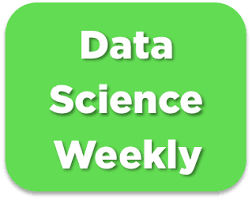

# Challenge : predict conversions 🏆🏆

This is the template that shows the different steps of the challenge. In this notebook, all the training/predictions steps are implemented for a very basic model (logistic regression with only one variable). Please use this template and feel free to change the preprocessing/training steps to get the model with the best f1-score ! May the force be with you 🧨🧨  

**For a detailed description of this project, please refer to *02-Conversion_rate_challenge.ipynb*.**

# Import libraries

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
# setting Jedha color palette as default
pio.templates["jedha"] = go.layout.Template(
    layout_colorway=["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]
)
pio.templates.default = "jedha"
pio.renderers.default = "svg" # to be replaced by "iframe" if working on JULIE
from IPython.display import display

# Read file with labels

In [2]:
data = pd.read_csv('conversion_data_train.csv')
print('Set with labels (our train+test) :', data.shape)

Set with labels (our train+test) : (284580, 6)


In [3]:
# % conversion in China
data_china = data[data['country'] == 'China']
print((data_china.value_counts('converted')[1] / data_china.shape[0])*100)

# % conversion in US
data_us = data[data['country'] == 'US']
print((data_us.value_counts('converted')[1] / data_us.shape[0])*100)

# % conversion in UK
data_uk = data[data['country'] == 'UK']
print((data_uk.value_counts('converted')[1] / data_uk.shape[0])*100)

# % conversion in Germany
data_de = data[data['country'] == 'Germany']
print((data_de.value_counts('converted')[1] / data_de.shape[0])*100)

# data without China
#data = data[~(data['country'] == 'China')]

0.12875784844188537
3.79081212060653
5.24965055796155
6.2430513982724705


In [4]:
#data['pagesages'] = data['total_pages_visited'] * data['age']

In [5]:
print(f"Number of rows : {data.shape[0]}")
print()

print("Display of dataset: ")
display(data.head())
print()

print("Basics statistics: ")
display(data.describe(include='all'))
print()

print("Percentage of missing values: ")
display(100 * data.isnull().sum() / data.shape[0])


Number of rows : 284580

Display of dataset: 


,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0
1,UK,21,1,Ads,3,0
2,Germany,20,0,Seo,14,1
3,US,23,1,Seo,3,0
4,US,28,1,Direct,3,0



Basics statistics: 


,country,age,new_user,source,total_pages_visited,converted
count,284580,284580.000000,284580.000000,284580,284580.000000,284580.000000
unique,4,NaN,NaN,3,NaN,NaN
top,US,NaN,NaN,Seo,NaN,NaN
freq,160124,NaN,NaN,139477,NaN,NaN
mean,NaN,30.564203,0.685452,NaN,4.873252,0.032258
std,NaN,8.266789,0.464336,NaN,3.341995,0.176685
min,NaN,17.000000,0.000000,NaN,1.000000,0.000000
25%,NaN,24.000000,0.000000,NaN,2.000000,0.000000
50%,NaN,30.000000,1.000000,NaN,4.000000,0.000000
75%,NaN,36.000000,1.000000,NaN,7.000000,0.000000



Percentage of missing values: 


country                0.0
age                    0.0
new_user               0.0
source                 0.0
total_pages_visited    0.0
converted              0.0
dtype: float64

In [6]:
(data.groupby('country').sum()['converted'] / data.groupby('country').count()['converted']) * 100

country
China      0.128758
Germany    6.243051
UK         5.249651
US         3.790812
Name: converted, dtype: float64

In [7]:
data['age'].sort_values(ascending=False)

233196    123
11331     111
230590     79
268311     77
175251     73
         ... 
114803     17
151330     17
72137      17
151323     17
21340      17
Name: age, Length: 284580, dtype: int64

In [8]:
# fig = px.histogram(data, x='age')
# fig.show()
# fig = px.histogram(data, x='country') # déséquilibre avec bcp US, et peu DE
# fig.show()
# fig = px.histogram(data, x='source')
# fig.show()
# fig = px.histogram(data, x='new_user')
# fig.show()
# fig = px.histogram(data, x='total_pages_visited')
# fig.show()

# fig = px.bar(data, x='source', y='converted') # faire la proportion
# fig.show()

In [9]:
# import seaborn as sns
# sns.pairplot(data)

# Explore dataset

In [10]:
# The dataset is quite big : you must create a sample of the dataset before making any visualizations !
data_sample = data.sample(10000)

# Make your model

## Choose variables to use in the model, and create train and test sets
**From the EDA, we know that the most useful feature is total_pages_visited. Let's create a baseline model by using at first only this feature : in the next cells, we'll make preprocessings and train a simple (univariate) logistic regression.**

In [11]:
features_list = ['country','age','new_user','source','total_pages_visited']
numerical_features = ['age','total_pages_visited']
categorical_features = ['country','new_user','source']
target_variable = 'converted'

In [12]:
def add_feature(df_final, name):
  df_final[f'{name}_x2'] = df_final[f'{name}']**2
  df_final[f'{name}_x3'] = df_final[f'{name}']**3
  df_final[f'{name}_x4'] = df_final[f'{name}']**4
  df_final[f'{name}_1x'] = 1 / df_final[f'{name}']
  df_final[f'{name}_1x2'] = 1 / (df_final[f'{name}']**2)
  return df_final

#add_feature(data, 'total_pages_visited')

numerical_features = [c for c in data.columns if c not in categorical_features and c != 'converted']
features_list = [c for c in data.columns if c != 'converted']
features_list

['country', 'age', 'new_user', 'source', 'total_pages_visited']

In [13]:
X = data.loc[:, features_list]
Y = data.loc[:, target_variable]

print('Explanatory variables : ', X.columns)
print()

Explanatory variables :  Index(['country', 'age', 'new_user', 'source', 'total_pages_visited'], dtype='object')



In [14]:
# Divide dataset Train set & Test set 
print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=0, stratify=Y)
print("...Done.")
print()
# https://sarit-maitra.medium.com/boosting-algorithms-adaboost-rusboost-smoteboost-for-highly-imbalanced-class-8333febf3280

Dividing into train and test sets...
...Done.



In [15]:
Y_train.sum()

8262

In [16]:
# Convert pandas DataFrames to numpy arrays before using scikit-learn
# print("Convert pandas DataFrames to numpy arrays...")
# X_train = X_train.values
# X_test = X_test.values
# Y_train = Y_train.values
# Y_test = Y_test.values
# print("...Done")

# print(X_train[0:5,:])
# print(X_test[0:2,:])
# print()
# print(Y_train[0:5])
# print(Y_test[0:2])

## Training pipeline

In [17]:
# Put here all the preprocessings
print("Encoding categorical features and standardizing numerical features...")

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

numerical_transformer = Pipeline(steps=[
    #('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])


categorical_transformer = Pipeline(
    steps=[
    #('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(drop='first'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

Encoding categorical features and standardizing numerical features...


In [24]:
# Train model
# print("Train model...")
# classifier = LogisticRegression() # 
# classifier.fit(X_train, Y_train)
# print("...Done.")

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, VotingClassifier, BaggingRegressor,\
StackingRegressor, RandomForestRegressor, StackingClassifier, HistGradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier, Lasso
from sklearn.metrics import f1_score, accuracy_score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
#import lightgbm as lgbm

import xgboost as xgb

hp_random_forest = {
    'n_estimators': [30, 50, 70],
    'max_depth': [10, 30, 50],
    'min_samples_split': [250],
    'min_samples_leaf': [20, 30, 40],
   # 'class_weight': ['balanced'],
    'criterion': ['entropy']

}
h_random_forest2 = {
    'base_estimator__criterion': ['entropy'],
    'base_estimator__max_depth': [30],
    'base_estimator__min_samples_leaf': [30],
    'base_estimator__min_samples_split': [250],
    'base_estimator__n_estimators': [50],
    'n_estimators': [20]
    }
hp_random_forest = {'criterion': ['entropy'], 'max_depth': [30], 'min_samples_leaf': [30], 'min_samples_split': [250], 'n_estimators': [50]}
# hp_random_forest = {'max_depth': [20], 'min_samples_leaf': [4], 'min_samples_split': [15], 'n_estimators': [100]}
hp_logistic_regression = {
    'max_iter': [50, 100, 200],
    #'class_weight': ['balanced']
     
}
hp_ridge = {
    'alpha': [0.001, 0.005,0.01, 0.03, 0.05],
    'max_iter': [20, 50, 100, 200],
    'class_weight': ['balanced']
     
}
hp_svc = {
# 'C': [8, 10, 20, 30],
# 'gamma': [0.1, 0.3, 0.5, 0.8, 2]
    'C': [10],
    'gamma': [0.5],
    #'class_weight': ['balanced']
}
hp_xgb = { # winner
    'max_depth': [4], #good
    'n_estimators': [73],
    'learning_rate':  [0.135],
    'min_child_weight': [1],
    'gamma':[4.915], # good
    #'subsample':[0.95, 0.97, 0.99, 1], good
    #'lambda': [0.98,1,1.02], good
    'objective': ['binary:logistic'],
    'scale_pos_weight': [1.52], # good
    'eval_metric':['rmse']
}
# hp_xgb = {
#     'max_depth': [4], #good
#     'n_estimators': [73],
#     'learning_rate':  [0.134,0.135,0.136],
#     'min_child_weight': [1],
#     'gamma':[4.914,4.915,4.916], # good
#     #'subsample':[0.95, 0.97, 0.99, 1], good
#     #'lambda': [0.98,1,1.02], good
#     'objective': ['binary:logistic'],
#     'scale_pos_weight': [1.515,1.52,1.525], # good
#     'eval_metric':['rmse']
# }
hp_lgbm = { # winner
    'max_depth': [2], 
    'n_estimators': [220],
    'learning_rate':  [0.1], # good
    #'min_child_weight': [2],
    #'gamma':[4.5, 4.915, 6], # good
    #'subsample':[0.95, 0.97, 0.99, 1],
    #'lambda': [0.98,1,1.02],
    'scale_pos_weight': [1.55],
    'min_split_gain': [0.27],
    'num_leaves': [4, 5],
    'min_child_samples':[75],
    'min_child_weight':[0.0001],
    'subsample_for_bin': [150000],
    'min_data_in_leaf': [80]
}
 #{'learning_rate': 0.1, 'max_depth': 2, 'min_child_samples': 80, 'min_child_weight': 2, 'min_split_gain': 0.25, 'n_estimators': 220, 'num_leaves': 5, 'scale_pos_weight': 1.55}
        # "n_estimators": trial.suggest_categorical("n_estimators", [10000]),
        # "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        # "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20),
        # "max_depth": trial.suggest_int("max_depth", 3, 12),
        # "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step=100),
        # "max_bin": trial.suggest_int("max_bin", 200, 300),
        # "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
        # "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
        # "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        # "bagging_fraction": trial.suggest_float(
        #     "bagging_fraction", 0.2, 0.95, step=0.1
        # ),
        # "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        # "feature_fraction": trial.suggest_float(
        #     "feature_fraction", 0.2, 0.95, step=0.1
        # ),

#Best hyper parameters :  {'eval_metric': 'rmse', 'gamma': 4.915, 'learning_rate': 0.135, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 73, 'objective': 'binary:logistic', 'scale_pos_weight': 1.52}

# https://www.kaggle.com/code/prashant111/a-guide-on-xgboost-hyperparameters-tuning/notebook
# https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html
# https://towardsdatascience.com/kagglers-guide-to-lightgbm-hyperparameter-tuning-with-optuna-in-2021-ed048d9838b5

# model_lgbm = GridSearchCV(lgbm.LGBMClassifier(n_jobs=-1, objective= 'binary', seed=42), param_grid = hp_lgbm, scoring='f1', n_jobs=-1, cv=2, verbose=2)
# model_lgbm.fit(X_train, Y_train)

model_xgb = xgb.XGBClassifier(n_jobs=-1, objective= 'binary:logistic', nthread=4, seed=42)
classifier_xgb = GridSearchCV(model_xgb, param_grid = hp_xgb, scoring='f1', n_jobs=-1, cv=5, verbose=2)
classifier_xgb.fit(X_train, Y_train)

hp_ada_tree = {
    'n_estimators': [30],
    'base_estimator__max_depth': [10, 30, 50],
    'base_estimator__min_samples_split': [20, 50, 100, 250],
    'base_estimator__min_samples_leaf': [5, 20, 30, 40],
    'base_estimator__criterion': ['entropy']

   # 'class_weight': ['balanced'],
}

# classifier_forest = GridSearchCV(RandomForestClassifier(), param_grid = hp_random_forest, scoring='f1', verbose=2, n_jobs=-1, cv=2)
# classifier_forest.fit(X_train, Y_train)
# estimator_forest = classifier_forest.best_estimator_
# print("classifier_forest done")

# classifier_svc = GridSearchCV(SVC(kernel='rbf', probability=True), param_grid = hp_svc, scoring='f1', n_jobs=-1, verbose=2, cv=2)
# #classifier_svc.fit(X_train, Y_train)
# print("classifier_svc done")

# classifier_logreg = GridSearchCV(LogisticRegression(), param_grid = hp_logistic_regression, scoring='f1', verbose=2, n_jobs=-1, cv=2)
# #classifier_logreg.fit(X_train, Y_train)
# print("classifier_logreg done")

# bosser sur le weight
# voting = VotingClassifier(estimators=[
#     ('forest', classifier_forest), ('svc', classifier_svc), ('logreg', classifier_logreg)],
#     voting='soft', verbose=True)

# classifier_ridge = GridSearchCV(RidgeClassifier(), param_grid = hp_ridge, scoring='f1', n_jobs=-1, cv=5)
# classifier_ridge.fit(X_train, Y_train)

# baggingRegressor = BaggingClassifier(classifier_logreg, n_estimators=50)
# baggingRegressor.fit(X_train, Y_train)

# histGradientBoosting = HistGradientBoostingClassifier()
# histGradientBoosting.fit(X_train, Y_train)

# ada = AdaBoostClassifier(estimator_forest, n_estimators=20)
# ada.fit(X_train, Y_train)

# estimators = [
#     ('rdc', classifier_forest),
#     ('lr', classifier_logreg)
#     ]
# stackingRegressor = StackingClassifier(
#         estimators=estimators, final_estimator=LogisticRegression()
#     )
# stackingRegressor.fit(X_train, Y_train)

model = classifier_xgb

# print("Best hyper parameters : ", model.best_params_)
# print("Best score : ", model.best_score_)

Y_train_predict = model.predict(X_train)
Y_test_predict = model.predict(X_test)

print("F1 Score on training set : ", f1_score(Y_train_predict, Y_train))
print("F1 Score on test set : ", f1_score(Y_test_predict, Y_test))

#https://www.aquiladata.fr/insights/comment-gerer-le-desequilibre-des-classes-dans-un-jeu-de-donnees/
#https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_sample_weight.html


ValueError: k-fold cross-validation requires at least one train/test split by setting n_splits=2 or more, got n_splits=1.

In [ ]:
# from sklearn.model_selection import cross_val_score
# scores = cross_val_score(model, X_train, Y_train, cv=5, scoring='f1')
# print('The cross-validated score is : ', scores.mean())
# print('The standard deviation is : ', scores.std())

In [ ]:
print("Best hyper parameters : ", model.best_params_)
print("Best score : ", model.best_score_)
print("Best score : ", model.best_estimator_.get_params())

Best hyper parameters :  {'learning_rate': 0.1, 'max_depth': 2, 'min_child_samples': 75, 'min_child_weight': 0.0001, 'min_data_in_leaf': 80, 'min_split_gain': 0.27, 'n_estimators': 220, 'num_leaves': 4, 'scale_pos_weight': 1.55, 'subsample_for_bin': 150000}
Best score :  0.7705065839890786
Best score :  {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': 2, 'min_child_samples': 75, 'min_child_weight': 0.0001, 'min_split_gain': 0.27, 'n_estimators': 220, 'n_jobs': -1, 'num_leaves': 4, 'objective': 'binary', 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': 'warn', 'subsample': 1.0, 'subsample_for_bin': 150000, 'subsample_freq': 0, 'seed': 42, 'min_data_in_leaf': 80, 'scale_pos_weight': 1.55}


In [ ]:
data2 = data

features_list = ['country','age','new_user','source','total_pages_visited']
numerical_features = ['age','total_pages_visited']
categorical_features = ['country','new_user','source']
target_variable = 'converted'
X2 = data2.loc[:, features_list]
Y2 = data2.loc[:, target_variable]
# Divide dataset Train set & Test set 
print("Dividing into train and test sets...")
#X2_train, X2_test, Y2_train, Y2_test = train_test_split(X2, Y2, test_size=0.1, random_state=0, stratify=Y)
print("...Done.")
print()


Dividing into train and test sets...
...Done.



In [ ]:
X2 = preprocessor.transform(X2)
Y2_predict = model.predict(X2)
print('f1_score', f1_score(Y2, Y2_predict))
print('accuracy', accuracy_score(Y2, Y2_predict))

f1_score 0.7637497750854676
accuracy 0.9861585494412819


## Test pipeline

## Performance assessment

In [ ]:
# WARNING : Use the same score as the one that will be used by Kaggle !
# Here, the f1-score will be used to assess the performances on the leaderboard
print("f1-score on train set : ", f1_score(Y_train, Y_train_predict))
print("f1-score on test set : ", f1_score(Y_test, Y_test_predict))

f1-score on train set :  0.768411579421029
f1-score on test set :  0.7451332734351602


In [ ]:
# You can also check more performance metrics to better understand what your model is doing
print("Confusion matrix on train set : ")
print(confusion_matrix(Y_train, Y_train_predict))
print()
print("Confusion matrix on test set : ")
print(confusion_matrix(Y_test, Y_test_predict))
print()

Confusion matrix on train set : 
[[219168   1152]
 [  1991   5353]]

Confusion matrix on test set : 
[[54769   311]
 [  515  1321]]



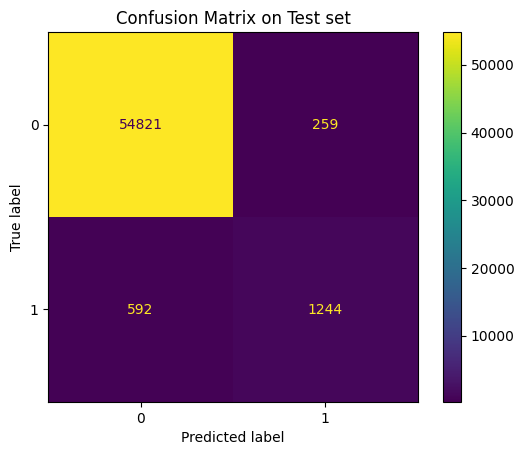

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
_ , ax = plt.subplots()
ax.set(title="Confusion Matrix on Test set")
ConfusionMatrixDisplay.from_estimator(model, X_test, Y_test, ax=ax)

**Our baseline model reaches a f1-score of almost 70%. Now, feel free to refine your model and try to beat this score ! 🚀🚀**

# Train best classifier on all data and use it to make predictions on X_without_labels
**Before making predictions on the file conversion_data_test.csv, let's train our model on ALL the data that was in conversion_data_train.csv. Sometimes, this allows to make tiny improvements in the score because we're using more examples to train the model.**

In [ ]:
sdsg

NameError: name 'sdsg' is not defined

In [ ]:
# Concatenate our train and test set to train your best classifier on all data with labels
X = np.append(X_train,X_test,axis=0)
Y = np.append(Y_train,Y_test)

model.fit(X,Y)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] END eval_metric=rmse, gamma=4.915, learning_rate=0.135, max_depth=4, min_child_weight=1, n_estimators=73, objective=binary:logistic, scale_pos_weight=1.52; total time=  10.7s
[CV] END eval_metric=rmse, gamma=4.915, learning_rate=0.135, max_depth=4, min_child_weight=1, n_estimators=73, objective=binary:logistic, scale_pos_weight=1.52; total time=  10.8s
[CV] END eval_metric=rmse, gamma=4.915, learning_rate=0.135, max_depth=4, min_child_weight=1, n_estimators=73, objective=binary:logistic, scale_pos_weight=1.52; total time=  10.9s
[CV] END eval_metric=rmse, gamma=4.915, learning_rate=0.135, max_depth=4, min_child_weight=1, n_estimators=73, objective=binary:logistic, scale_pos_weight=1.52; total time=  10.9s
[CV] END eval_metric=rmse, gamma=4.915, learning_rate=0.135, max_depth=4, min_child_weight=1, n_estimators=73, objective=binary:logistic, scale_pos_weight=1.52; total time=  10.9s
[CV] END eval_metric=rmse, gamma=4.915,

GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_c...
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=-1, nthread=4,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None, ...),
             n_jobs=-1,
             param_grid={'eval_metric': ['rmse'], 'gamma': [4.915],
                         'learning_rate': [0.135], 'max_depth': [4],
                         'min_child_weight': [1], 'n_estimators': [73],
                         'objective': ['binary:logistic'],
                         'scale_pos_weight': [1.52]},
             scoring='f1', verbose=2)

In [ ]:
# Read data without labels
data_without_labels = pd.read_csv('conversion_data_test.csv')
print('Prediction set (without labels) :', data_without_labels.shape)

#data_without_labels = data_without_labels[~(data_without_labels['country'] == "China")]

# Warning : check consistency of features_list (must be the same than the features 
# used by your best classifier)
#features_list = ['total_pages_visited']
X_without_labels = data_without_labels.loc[:, features_list]

# Convert pandas DataFrames to numpy arrays before using scikit-learn
print("Convert pandas DataFrames to numpy arrays...")
#X_without_labels = X_without_labels.values
print("...Done")

print(X_without_labels)

Prediction set (without labels) : (31620, 5)
Convert pandas DataFrames to numpy arrays...
...Done
       country  age  new_user  source  total_pages_visited
0           UK   28         0     Seo                   16
1           UK   22         1  Direct                    5
2        China   32         1     Seo                    1
3           US   32         1     Ads                    6
4        China   25         0     Seo                    3
...        ...  ...       ...     ...                  ...
31615  Germany   25         1     Seo                    3
31616       US   36         1     Ads                    7
31617       UK   33         1     Seo                    5
31618       UK   25         1     Seo                   14
31619       US   22         1     Seo                    2

[31620 rows x 5 columns]


In [ ]:
data_without_labels.value_counts('country')

country
US         17968
China       7480
UK          4809
Germany     1363
dtype: int64

In [ ]:
data_without_labels.head() # 0 à 1 et les 4 autres à 0

,country,age,new_user,source,total_pages_visited
0,UK,28,0,Seo,16
1,UK,22,1,Direct,5
2,China,32,1,Seo,1
3,US,32,1,Ads,6
4,China,25,0,Seo,3


In [ ]:
# WARNING : PUT HERE THE SAME PREPROCESSING AS FOR YOUR TEST SET
# CHECK YOU ARE USING X_without_labels
print("Encoding categorical features and standardizing numerical features...")

X_without_labels = preprocessor.transform(X_without_labels)
print("...Done")
print(X_without_labels[0:5,:])

Encoding categorical features and standardizing numerical features...
...Done
[[-0.31132378  3.3285935   0.          1.          0.          0.
   0.          1.        ]
 [-1.03650686  0.03743241  0.          1.          0.          1.
   1.          0.        ]
 [ 0.1721316  -1.15935344  0.          0.          0.          1.
   0.          1.        ]
 [ 0.1721316   0.33662888  0.          0.          1.          1.
   0.          0.        ]
 [-0.67391532 -0.56096051  0.          0.          0.          0.
   0.          1.        ]]


In [ ]:
Y_predictions = model.predict(X_without_labels)
Y_predictions

array([1, 0, 0, ..., 0, 1, 0])

In [ ]:
# Make predictions and dump to file
# WARNING : MAKE SURE THE FILE IS A CSV WITH ONE COLUMN NAMED 'converted' AND NO INDEX !
# WARNING : FILE NAME MUST HAVE FORMAT 'conversion_data_test_predictions_[name].csv'
# where [name] is the name of your team/model separated by a '-'
# For example : [name] = AURELIE-model1


# data = {
#     'converted': model.predict(X_without_labels)
# }

Y_predictions = pd.DataFrame(columns=['converted'],data=Y_predictions)
Y_predictions.to_csv('conversion_data_test_predictions_Julien-model3.csv', index=False, header=True)


In [ ]:
Y_predictions.loc[0,:] = 1
Y_predictions

,converted
0,1
1,0
2,0
3,0
4,0
...,...
31615,0
31616,0
31617,0
31618,1


In [ ]:
Y_predictions.loc[data_without_labels[data_without_labels['country'] == 'China'].index,:] = 0

AttributeError: 'numpy.ndarray' object has no attribute 'loc'

In [ ]:
Y_predictions.head(10)

,converted
0,1
1,0
2,2
3,0
4,2
5,0
6,2
7,0
8,0
9,0


## Analyzing the coefficients and interpreting the result
**In this template, we just trained a model with only one feature (total_pages_visited), so there's no analysis to be done about the feature importance 🤔**

**Once you've included more features in your model, please take some time to analyze the model's parameters and try to find some lever for action to improve the newsletter's conversion rate 😎😎**